In [6]:
import os
import math
import sys

import numpy as np
import scipy
from scipy.fft import fft2
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
from glob import glob
from hydra import initialize, compose

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='../../config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.analysis import ft
from mejiro.lenses.test import SampleSkyPyLens
from mejiro.plots import plot
from mejiro.utils import util

In [7]:
array_dir = os.path.join(array_dir, 'sample_skypy_lens')

In [8]:
k_min = (2 * np.pi) / 4.95
k_max = (2 * np.pi) / 0.11

# Different PSFs

In [9]:
psf_fwhm = {
    'f062': 0.058,
    'f087': 0.073,
    'f106': 0.087,
    'f129': 0.105,
    'f158': 0.127,
    'f184': 0.151,
    'f213': 0.175,
    'f146': 0.105
}

In [14]:
no_psf = np.load(os.path.join(array_dir, 'no_psf.npy'))
gaussian_psf = np.load(os.path.join(array_dir, 'gaussian_psf.npy'))
pandeia = np.load(os.path.join(array_dir, 'no_noise_or_background_5_10000.npy'))

psf_compare = [no_psf, gaussian_psf, pandeia]
psf_title_list = ['No PSF', 'Gaussian PSF (FWHM 0.087\")', 'Pandeia (WebbPSF)']

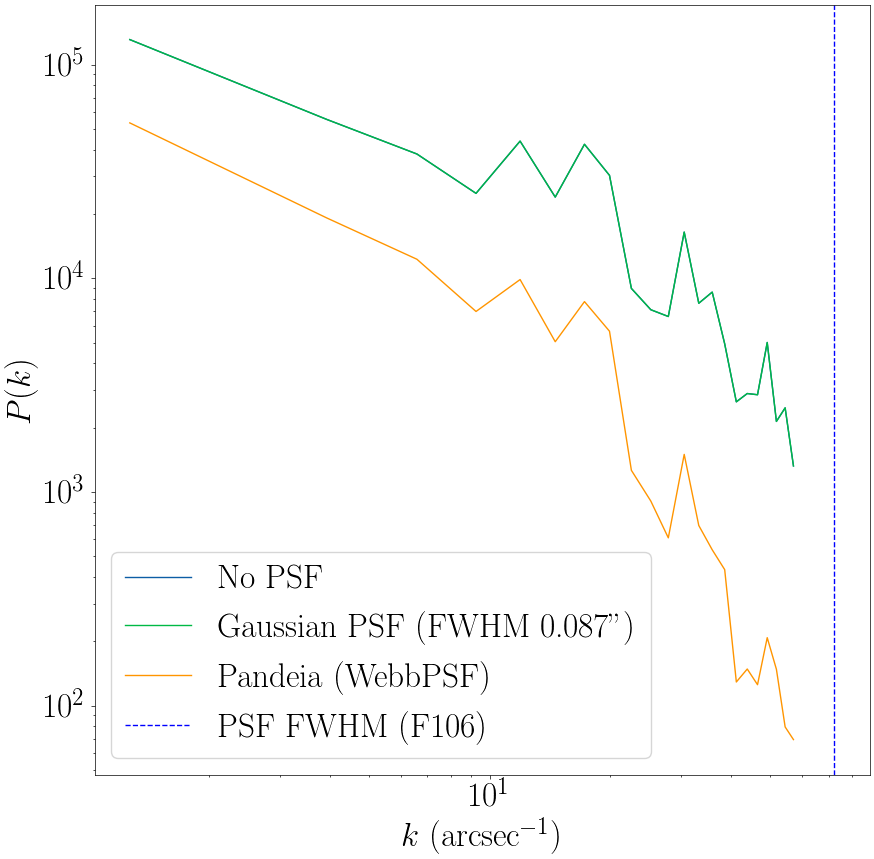

In [15]:
f, ax_psf = plt.subplots(figsize=(10, 10))

fontsize=24
matplotlib.rcParams.update({'font.size': fontsize})

for i, array in enumerate(psf_compare):
    kvals, Abins = ft.power_spectrum(array, k_min=k_min, k_max=k_max)
    data, = ax_psf.loglog(kvals, Abins)
    ax_psf.set_xlabel('$k$ (arcsec$^{-1}$)')
    ax_psf.set_ylabel('$P(k)$')
    data.set_label(f'{psf_title_list[i]}')

# PSF scale
fwhm = (2 * np.pi) / psf_fwhm['f106']
plt.axvline(x=fwhm, color='b', label='PSF FWHM (F106)', linestyle='dashed')

ax_psf.legend()

# Substructure vs. no substructure

In [16]:
no_substructure = np.load(os.path.join(array_dir, 'sample_skypy_lens_no_substructure_10000.npy'))
substructure = np.load(os.path.join(array_dir, 'sample_skypy_lens_5_10000.npy'))

substructure_compare = [no_substructure, substructure]
substructure_title_list = ['No substructure', 'Substructure']

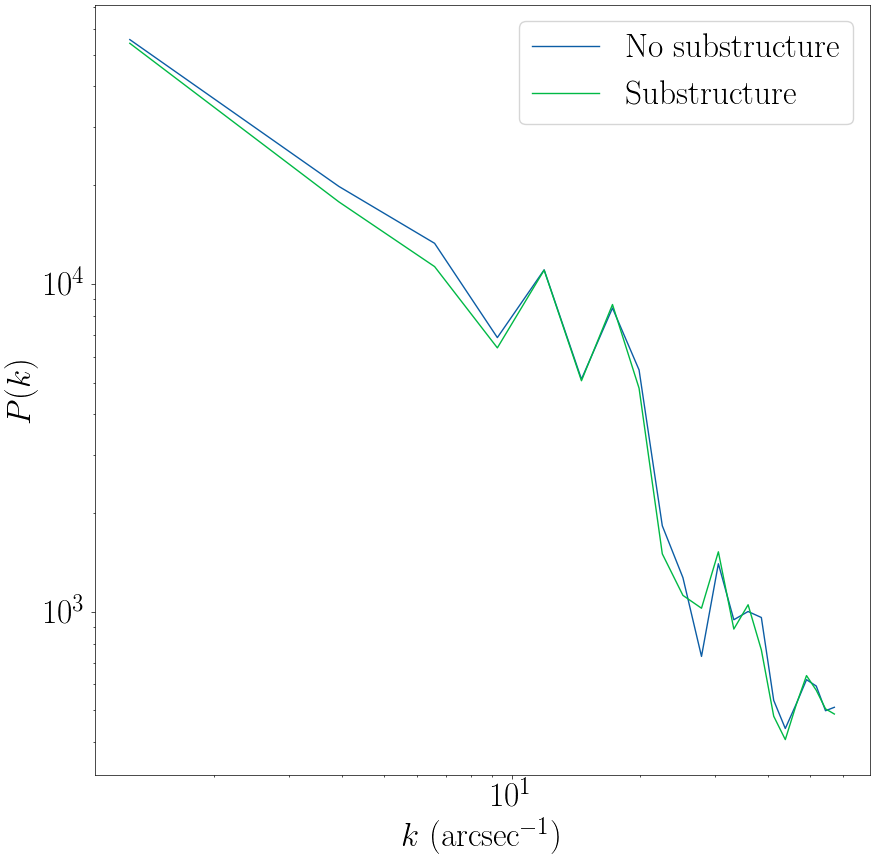

In [17]:
f, ax_substructure = plt.subplots(figsize=(10, 10))

# fontsize=24
# matplotlib.rcParams.update({'font.size': fontsize})

for i, array in enumerate(substructure_compare):
    kvals, Abins = ft.power_spectrum(array, k_min=k_min, k_max=k_max)
    data, = ax_substructure.loglog(kvals, Abins)
    ax_substructure.set_xlabel('$k$ (arcsec$^{-1}$)')
    ax_substructure.set_ylabel('$P(k)$')
    data.set_label(f'{substructure_title_list[i]}')

ax_substructure.legend()

# Vary number of samples

In [18]:
file_list = glob(array_dir + '/sample_skypy_lens_1_*.npy')
num_sample_compare = [np.load(i) for i in file_list]
samples_title_list = []

for file in file_list:
    basename = os.path.basename(file)
    basename = basename[:-4]
    title = basename.removeprefix('sample_skypy_lens_')
    title = '{:.0e}'.format(int(title))
    samples_title_list.append(f'{title} samples')

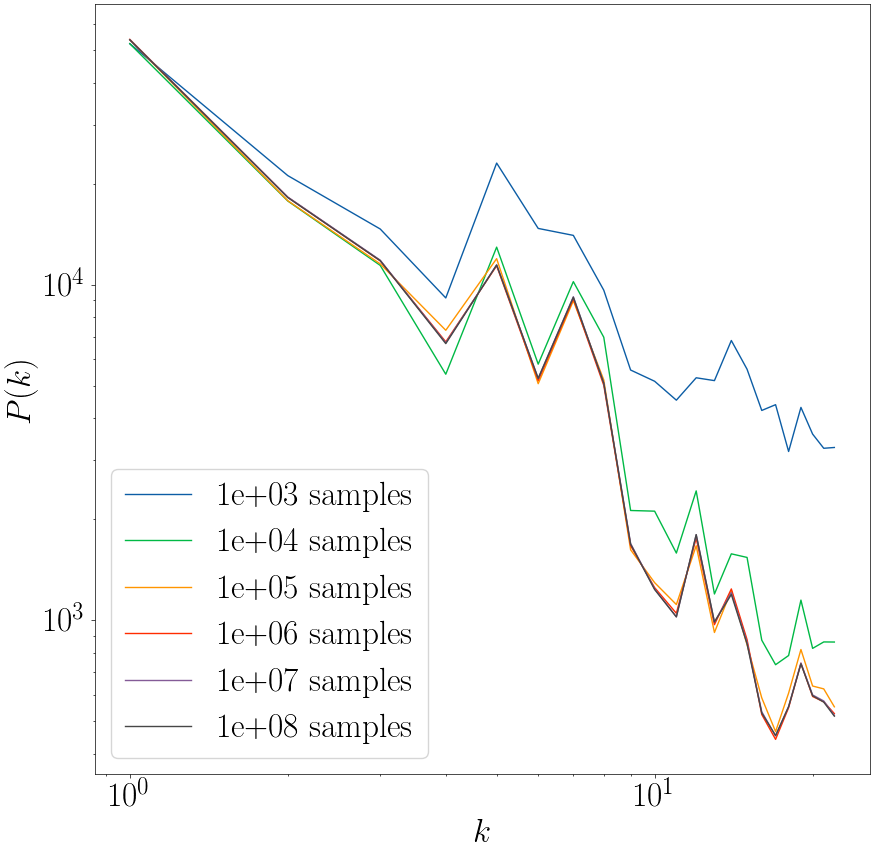

In [19]:
f, ax_samples = plt.subplots(figsize=(10, 10))

fontsize=24
matplotlib.rcParams.update({'font.size': fontsize})

for i, array in enumerate(num_sample_compare):
    kvals, Abins = ft.power_spectrum(array)
    data, = ax_samples.loglog(kvals, Abins)
    ax_samples.set_xlabel('$k$')
    ax_samples.set_ylabel('$P(k)$')
    data.set_label(f'{samples_title_list[i]}')

ax_samples.legend()

# 2D FT

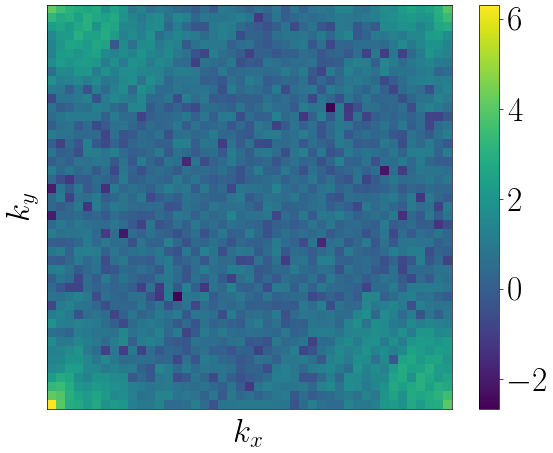

In [20]:
plt.imshow(np.log10(ft.twod_ft(substructure)))
# plt.title('Fourier amplitudes of 9-times oversampled Pandeia simulation')
plt.xlabel('$k_x$')
plt.ylabel('$k_y$')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar()
# cbar.set_label('$\log_{10}$')
plt.show()

# Combine

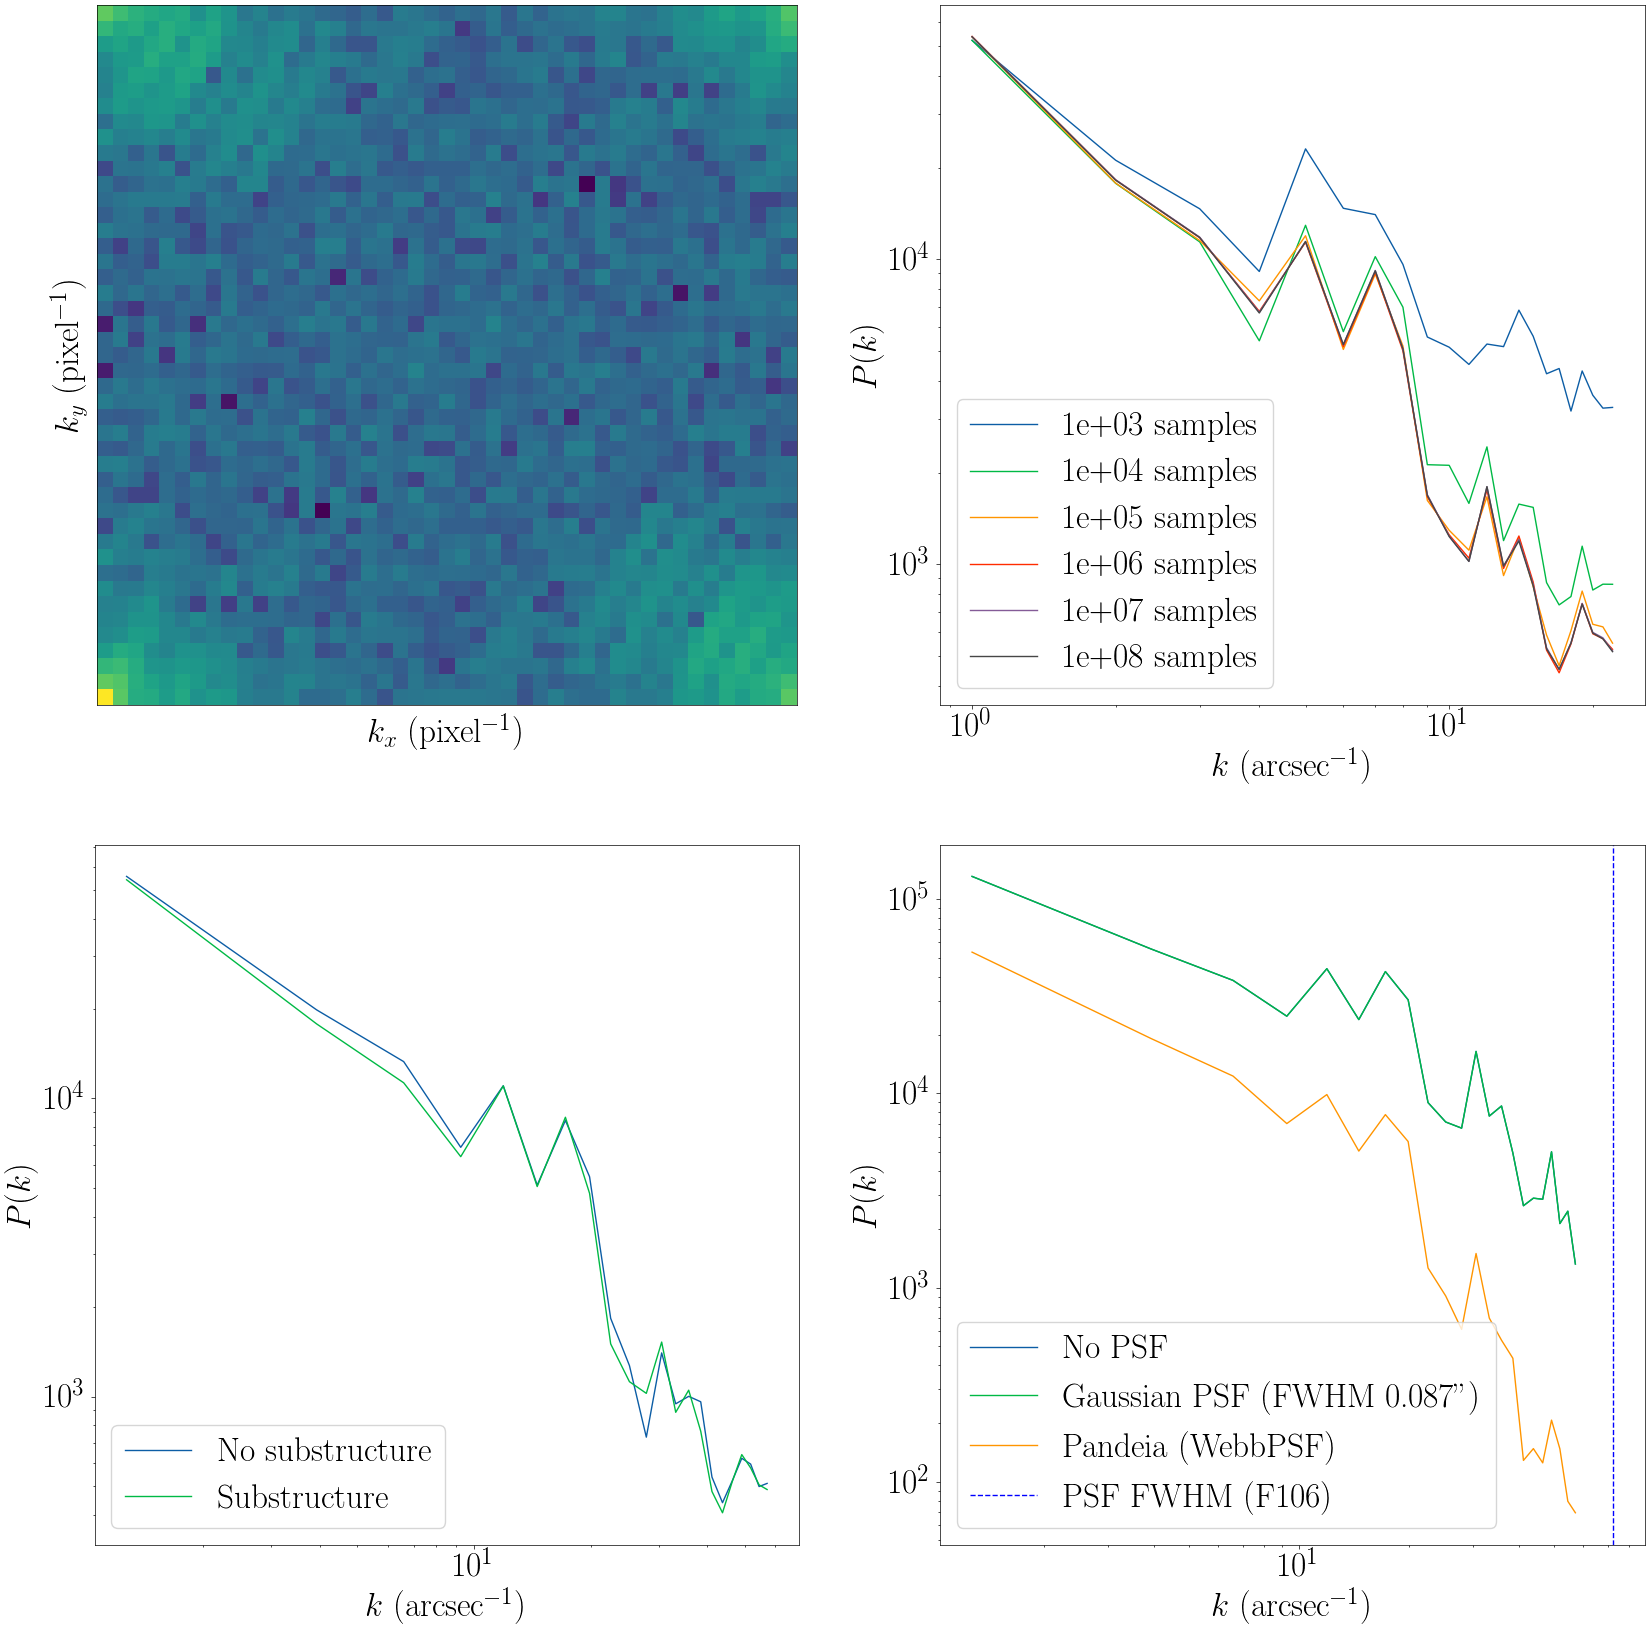

In [23]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

# fontsize = 24
# matplotlib.rcParams.update({'font.size': fontsize})

# 2D FT
ax[0][0].imshow(np.log10(ft.twod_ft(substructure)))
ax[0][0].set_xlabel('$k_x$ (pixel$^{-1}$)')
ax[0][0].set_ylabel('$k_y$ (pixel$^{-1}$)')
ax[0][0].set_xticks([])
ax[0][0].set_yticks([])

# num samples
for i, array in enumerate(num_sample_compare):
    kvals, Abins = ft.power_spectrum(array)
    data, = ax[0][1].loglog(kvals, Abins)
    ax[0][1].set_xlabel('$k$ (arcsec$^{-1}$)')
    ax[0][1].set_ylabel('$P(k)$')
    data.set_label(f'{samples_title_list[i]}')
ax[0][1].legend()

# substructure
for i, array in enumerate(substructure_compare):
    kvals, Abins = ft.power_spectrum(array, k_min=k_min, k_max=k_max)
    data, = ax[1][0].loglog(kvals, Abins)
    ax[1][0].set_xlabel('$k$ (arcsec$^{-1}$)')
    ax[1][0].set_ylabel('$P(k)$')
    data.set_label(f'{substructure_title_list[i]}')
ax[1][0].legend(loc='lower left')

# vary PSF
for i, array in enumerate(psf_compare):
    kvals, Abins = ft.power_spectrum(array, k_min=k_min, k_max=k_max)
    data, = ax[1][1].loglog(kvals, Abins)
    ax[1][1].set_xlabel('$k$ (arcsec$^{-1}$)')
    ax[1][1].set_ylabel('$P(k)$')
    data.set_label(f'{psf_title_list[i]}')

# PSF scale
fwhm = (2 * np.pi) / psf_fwhm['f106']
ax[1][1].axvline(x=fwhm, color='b', label='PSF FWHM (F106)', linestyle='dashed')
ax[1][1].legend()

plt.savefig(os.path.join(figure_dir, 'power_spectra.png'))
plt.show()